사용자 데이터를 사용하는 방법

**진행순서**
1. 나만의 데이터 셋 준비
2. torvision.datasets.ImageFolder로 불러오기
3. transforms 적용하여 저장하기
origin_data -> train_data

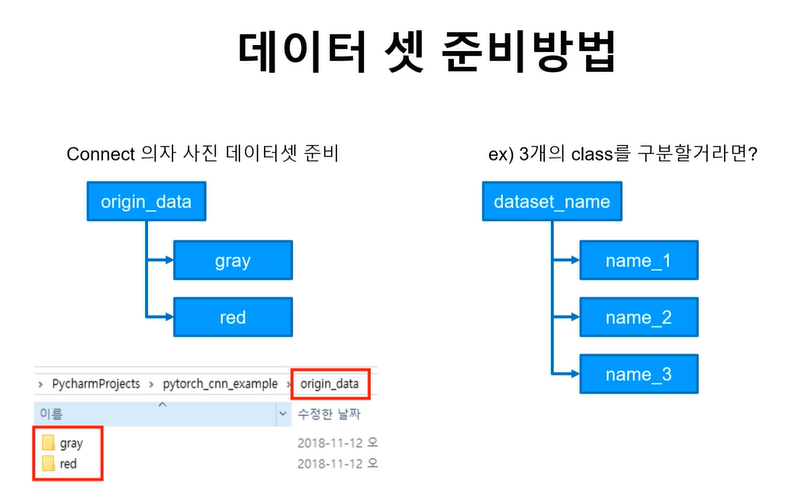

주피터노트북으로 할경우, 주피터노트북파일과 data폴더의 상대적 위치로,,, 혹은 코랩일 경우, 구글드라이브에 data넣어두고 상대적 위치로!

나는 이 파일이랑 같은 위치의 origin_data폴더안에 gray, red 폴더만들고 사진 1개씩만 넣어두었음

코랩환경에서 구글 드라이브 데이터 가져오는 방법: https://metar.tistory.com/entry/ImageFolder-%EC%9A%B0%ED%95%9C%ED%8F%90%EB%A0%B4-%EB%B6%84%EB%A5%98%ED%95%B4%EB%B3%B4%EA%B8%B0

# 과정 설명용

In [ ]:
import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader

In [ ]:
from matplotlib.pyplot import imshow #image 보이게
%matplotlib inline 
#matplotlib의 출력값이 여기서 보이게 하는 것

In [ ]:
#이파일 하위에 있는 것 확인
!ls

drive  sample_data


In [ ]:
cd drive/MyDrive/Colab\ Notebooks/Pytorch기초/03_CNN

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/Pytorch기초/03_CNN'
/content/drive/MyDrive/Colab Notebooks/Pytorch기초/03_CNN


In [ ]:
!ls

'CNN으로 MNIST 분류.ipynb'   ImageFolder.ipynb	 origin_data   wandb.ipynb


In [ ]:
pwd

'/content/drive/My Drive/Colab Notebooks/Pytorch기초/03_CNN'

In [36]:
train_data = torchvision.datasets.ImageFolder(root = 'Custom_data/origin_data', transform = None)

0 <PIL.Image.Image image mode=RGB size=960x640 at 0x7F2E888CDD10> 0
1 <PIL.Image.Image image mode=RGB size=721x960 at 0x7F2E88810710> 1


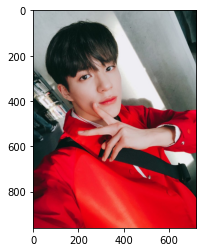

In [37]:
#잘 불러왔는 지 확인
for num, value in enumerate(train_data):
  data, label = value
  print(num, data, label) 
  imshow(data)

In [39]:
#image resize
#transform이 많을 경우 일일이 transform = ~~써주는 것이 아니라 여기에 적고 계속 쓰기
trans = transforms.Compose([
    transforms.Resize((64,128))                        
])

train_data = train_data = torchvision.datasets.ImageFolder(root = 'Custom_data/origin_data', transform = trans)

0 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F2E887E47D0> 0
1 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F2E8877D290> 1


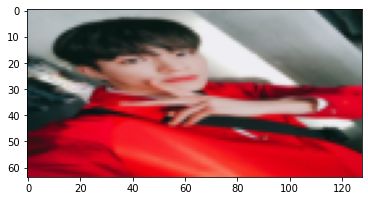

In [40]:
#잘 불러왔는 지 확인
for num, value in enumerate(train_data):
  data, label = value
  print(num, data, label) 
  imshow(data)

Resize한 데이터 저장하기

In [41]:
#잘 불러왔는 지 확인
for num, value in enumerate(train_data):
  data, label = value
  print(num, data, label) 
  if(label == 0):
    data.save('Custom_data/train_data/gray/%d_%d.jpeg'%(num,label))
    #FileNotFoundError: [Errno 2] No such file or directory: 'train_data/gray/0_0.jpeg'
    #폴더 만들어줘야!
  else:
    data.save('Custom_data/train_data/red/%d_%d.jpeg'%(num,label))

0 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F2E88735BD0> 0
1 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F2E887B3610> 1


학습
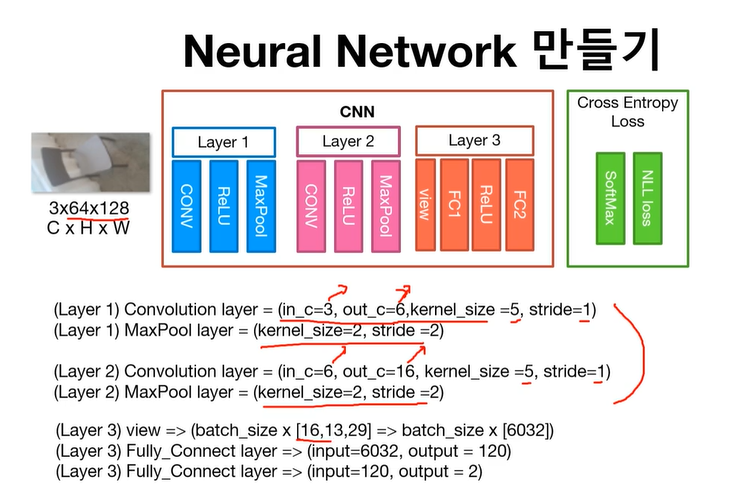

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [43]:
#GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [46]:
batch_size = 1 #수정
learning_rate = 0.00001
num_epochs = 15


In [45]:
trans = transforms.Compose([
  transforms.ToTensor()
])
train_data = torchvision.datasets.ImageFolder(root = 'Custom_data/train_data', transform = trans)

In [47]:
data_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True, num_workers=2)

In [64]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3,6,5),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(6,16,5),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer3 = nn.Sequential(
        nn.Linear(16*13*29, 120),
        nn.ReLU(),
        nn.Linear(120, 2) #2: num_classes
    )

  def forward(self, x):
    out = self.layer1(x)
    #print(out.shape)
    out = self.layer2(out)
    #print(out.shape)
    out = out.view(out.shape[0],-1)
    #print(out.shape)
    out = self.layer3(out)
    return out



In [65]:
#model 문제없는 지 확인
model = CNN()#.to(device)
test_input = torch.Tensor(3,3,64,128) #.to(device) batch_size, C, H, W
test_out = model(test_input)
print(test_out)


tensor([[ 0.0591, -0.0781],
        [ 0.0584, -0.0782],
        [ 0.0595, -0.0776]], grad_fn=<AddmmBackward0>)


In [66]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_func = nn.CrossEntropyLoss()#.to(device)

In [67]:
total_batch = len(data_loader)

epochs = num_epochs
for epoch in range(epochs):
  avg_cost = 0.0
  for num, data in enumerate(data_loader):
    imgs, labels = data
    imgs = imgs#.to(device)
    laels = labels#.to(device)
    
    optimizer.zero_grad()
    hypothesis = model(imgs)
    loss = loss_func(hypothesis, labels)
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch
  print('[Epoch:{}] cost = {}'.format(epoch + 1, avg_cost))
print('Learning Finished')


[Epoch:1] cost = 0.7007054090499878
[Epoch:2] cost = 0.6995227336883545
[Epoch:3] cost = 0.6979186534881592
[Epoch:4] cost = 0.6972726583480835
[Epoch:5] cost = 0.6972780227661133
[Epoch:6] cost = 0.6960211992263794
[Epoch:7] cost = 0.6955286264419556
[Epoch:8] cost = 0.6956429481506348
[Epoch:9] cost = 0.6944788694381714
[Epoch:10] cost = 0.6939953565597534
[Epoch:11] cost = 0.6934911012649536
[Epoch:12] cost = 0.6929763555526733
[Epoch:13] cost = 0.6930813789367676
[Epoch:14] cost = 0.6919705867767334
[Epoch:15] cost = 0.6920243501663208
Learning Finished


In [68]:
#학습시킨 모델을 save
torch.save(model.state_dict(), "./model/model.path")

FileNotFoundError: ignored

In [ ]:
new_net = CNN()#.to(device)

In [ ]:
#학습시킨 모델 불러오기
new_net.load_state_dict(torch.load('./model/model.path'))

In [ ]:
#잘 불러왔는지 확인
print(model.layer1[0])
print(new_net.layer1[0])

print(model.laye1[0].weight[0][0][0])
print(new_net.laye1[0].weight[0][0][0])

model.laye1[0].weight[0] == new_net.laye1[0].weight[0]


In [ ]:
#TEST DATA
trans = torchvision.transforms.Compose([
  transforms.Resize((64,128)),
  transforms.ToTensor()                                        
])
test_data = torchvision.datasets.ImageFolder(root = 'Custom_data/test_data', transform = trans)

In [ ]:
test_set = DataLoader(dataset = test_data, batch_size = len(test_data))

In [ ]:
with torch.no_grad():
  for num, data in enumerate(test_set):
    imgs,label = data
    imgs = imgs#.to(device)
    label = label#.to(device)

    prediction = model(imgs)
    correct_prediction = torch.argmax(prediction, axis = 1) == label

    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

# 코드만

In [ ]:
import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader

In [ ]:
from matplotlib.pyplot import imshow #image 보이게
%matplotlib inline 
#matplotlib의 출력값이 여기서 보이게 하는 것

In [ ]:
cd drive/MyDrive/Colab\ Notebooks/Pytorch기초/03_CNN

In [ ]:
#image resize
#transform이 많을 경우 일일이 transform = ~~써주는 것이 아니라 여기에 적고 계속 쓰기
trans = transforms.Compose([
    transforms.Resize((64,128))                        
])

train_data = train_data = torchvision.datasets.ImageFolder(root = 'Custom_data/origin_data', transform = trans)

In [ ]:
#잘 불러왔는 지 확인
for num, value in enumerate(train_data):
  data, label = value
  print(num, data, label) 
  if(label == 0):
    data.save('Custom_data/train_data/gray/%d_%d.jpeg'%(num,label))
    #FileNotFoundError: [Errno 2] No such file or directory: 'train_data/gray/0_0.jpeg'
    #폴더 만들어줘야!
  else:
    data.save('Custom_data/train_data/red/%d_%d.jpeg'%(num,label))